<a href="https://colab.research.google.com/github/AnetaKovacheva/text_classification_pyspark/blob/main/Text_Classification_with_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification with PySpark

In this Notebook, I explore and classify the legal text data, available on [Kaggle](https://www.kaggle.com/datasets/shivamb/legal-citation-text-classification). The dataset contains legal cases from the Federal Court of Australia. All cases are from 2006, 2007, 2008 and 2009. Catchphrases, citations sentences, citation catchphrases, and citation classes are captured for each document. Citation classes indicate the type of treatment given to the cases cited by the present case. There are more than 20000 cases in the dataset.

I use PySpark to explore, clean, preprocess, and model the data.

### Install PySpark

The code lines below install PySpark in Google Colab.

In [1]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
# !tar xf spark-3.1.1-bin-hadoop3.2.tgz
# !pip install -q findspark

### Imports

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import length, col, rand, count
from pyspark.ml.feature import CountVectorizer, Tokenizer, StopWordsRemover, IDF, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Load Data

A Spark session is greated. The dataset is loaded in `df`. Its schema shows that it has four columns with string values.

In [3]:
spark = SparkSession.builder.appName("nlp").getOrCreate()
df = spark.read.csv("legal_text_classification.csv", inferSchema = True, header = True)
df.printSchema()

root
 |-- case_id: string (nullable = true)
 |-- case_outcome: string (nullable = true)
 |-- case_title: string (nullable = true)
 |-- case_text: string (nullable = true)



## 2. Exploratory Data Analysis, data cleansing, and visualizations

The first 5 rows are displayed below. It seems that only "case_outcome" (the label column) and "case_text" will be needed for classifying the legal texts.

In [4]:
df.show(5)

+-------+------------+--------------------+--------------------+
|case_id|case_outcome|          case_title|           case_text|
+-------+------------+--------------------+--------------------+
|  Case1|       cited|Alpine Hardwood (...|Ordinarily that d...|
|  Case2|       cited|Black v Lipovac [...|"The general prin...|
|  Case3|       cited|Colgate Palmolive...|Ordinarily that d...|
|  Case4|       cited|Dais Studio Pty L...|"The general prin...|
|  Case5|       cited|Dr Martens Austra...|The preceding gen...|
+-------+------------+--------------------+--------------------+
only showing top 5 rows



For this reason, the unnecessary columns were removed.

In [5]:
df = df.drop("case_id", "case_title")
df.show(3)

+------------+--------------------+
|case_outcome|           case_text|
+------------+--------------------+
|       cited|Ordinarily that d...|
|       cited|"The general prin...|
|       cited|Ordinarily that d...|
+------------+--------------------+
only showing top 3 rows



In [6]:
def shape(df):
  """
  Print Spark DataFrame shape
  Args: DataFrame
  """
  print(f"number of rows: {df.count()}, number of columns: {len(df.columns)}")

The dataset has 24985 samples and 2 columns now.

In [7]:
shape(df)

number of rows: 24985, number of columns: 2


A brief check shows that there are null values in "case_text".

In [8]:
df.filter(df["case_text"].isNull()).show()

+------------+---------+
|case_outcome|case_text|
+------------+---------+
|    followed|     null|
|  considered|     null|
|       cited|     null|
|    affirmed|     null|
| referred to|     null|
|  considered|     null|
|    followed|     null|
|       cited|     null|
|       cited|     null|
|     applied|     null|
|       cited|     null|
|       cited|     null|
|       cited|     null|
|       cited|     null|
|       cited|     null|
|       cited|     null|
|       cited|     null|
| referred to|     null|
|   discussed|     null|
|       cited|     null|
+------------+---------+
only showing top 20 rows



All rows with Null values were removed. More than 100 samples had empty cells.

In [9]:
df = df.na.drop()
shape(df)

number of rows: 24809, number of columns: 2


It is important to have length of text sequences. The code line below computes it and stores it in a new column.

In [10]:
df = df.withColumn("length", length(df["case_text"]))
df.show(5)

+------------+--------------------+------+
|case_outcome|           case_text|length|
+------------+--------------------+------+
|       cited|Ordinarily that d...|   428|
|       cited|"The general prin...|   602|
|       cited|Ordinarily that d...|   428|
|       cited|"The general prin...|   602|
|       cited|The preceding gen...|   701|
+------------+--------------------+------+
only showing top 5 rows



It is interesting to see the average length of texts per type of case outcome. the first code line comuptes the mean values. Thereafter, the Spark dataframe is converted in Pandas dataframe to ease visualizations.

In [11]:
mean_length_by_outcome = df.groupBy("case_outcome").mean()
mean_length_by_outcome.show()
mean_length_by_outcome_pd = mean_length_by_outcome.toPandas()
mean_length_by_outcome_pd.set_index("case_outcome", inplace = True)

+-------------+------------------+
| case_outcome|       avg(length)|
+-------------+------------------+
|   considered|  1787.78634490877|
|      applied| 1668.094749794914|
|     approved|2588.6574074074074|
|distinguished|1626.2587064676618|
|        cited|1307.1624277456647|
|     affirmed|1264.9905660377358|
|     followed|1374.5466252220249|
|  referred to|1142.1652532661012|
|    discussed|1895.0913555992142|
|      related| 1856.294642857143|
+-------------+------------------+



Display of values count (distributions) is simplified with a function.

In [12]:
def distribution(df, col):
  """
  Displays counts (distribution) in categorical variable.
  Args: Spark DataFrame, column with categorical values (str)
  """
  plt.figure(figsize = (12, 4))
  plt.bar(df.index, df[col])
  plt.ylabel(f"{col}")
  plt.show()

The longest texts could be found in *approved* cases and the shortes - in *referred to* cases. Average text length vary between 1100 and 2600 words.

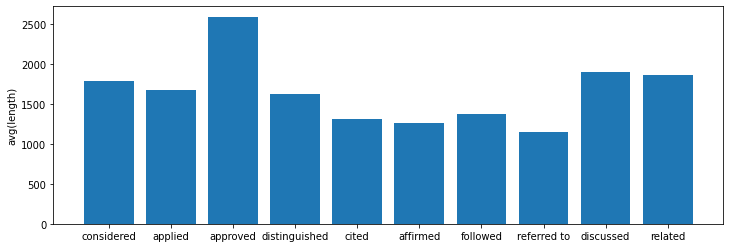

In [13]:
distribution(mean_length_by_outcome_pd, "avg(length)")

To simplify visualization of case outcome distribution, the function below aggregates data and converts a Spark into a Pandas dataframe, which then is passed to a Matplotlib object.

In [14]:
def make_pandas(df):
  """
  GroupBy data by categorical variable, does aggregation and
    converts Spark DataFrame into Pandas DataFrame
  Args: Spark DataFrame
  Returns: Pandas DataFrame with aggregated values.
  """
  aggr = df.groupBy("case_outcome").agg(count("case_outcome"))
  aggr_pd = aggr.toPandas()
  aggr_pd = aggr_pd.set_index("case_outcome")

  return aggr_pd

In [15]:
counted_cases_pd = make_pandas(df)

The plot below shows the dataset is quite imbalaced. There are more than 12000 *cited* cases and a tiny number of *approved*, *affirmed*, and *related*  ones. During preliminary work the dataset was balanced by upsampling but neither Decision Tree nor Random Forest - the classification algorithms used below - returned better scores. For this reason, the work proceeds with the imbalanced data. 

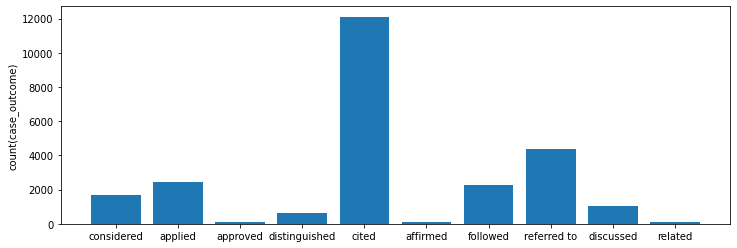

In [16]:
distribution(counted_cases_pd, "count(case_outcome)")

It turned out that both algorithms cause memory overload if trained on the whole dataset. For this reason, a random sample is taken out to train the models on less entries.

In [17]:
df_sample = df.limit(10000)

shape(df_sample)

number of rows: 10000, number of columns: 3


A brief check shows the sampled data have similar distribution of case outcomes (outcome types appear in different order, however).

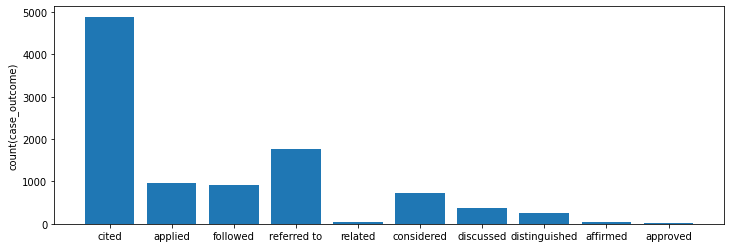

In [18]:
counted_sample_pd = make_pandas(df_sample)
distribution(counted_sample_pd, "count(case_outcome)")

Before being preprocessed for modelling, the sampled data are shuffled.

In [19]:
df_sample = df_sample.orderBy(rand())
df_sample.show(10)

+------------+--------------------+------+
|case_outcome|           case_text|length|
+------------+--------------------+------+
|     applied|"Based upon the e...|  1708|
|     applied|"are two addition...|   254|
| referred to|On this applicati...|   598|
|  considered|In oral submissio...|  1478|
|    affirmed|This is an applic...| 10294|
|    followed|"Although it is c...|   376|
|    followed|Customs argued th...|   850|
|  considered|"may be cases whe...|   285|
|       cited|See also Herrera ...|   206|
|       cited|"When the appeal ...|   235|
+------------+--------------------+------+
only showing top 10 rows



## 3. Data preprocessing

The code lines below tokenize senteces, remove stop words, vectorize tokens, peform IDF, and convert labels (case outcomes) to numeric value.

The `Tokenizer()` converts the input string to lowercase and then splits it by white spaces. Its input column is "case_text" and returns (output column) the tokenized text.

`StopWordsRemover()` filters out stop words from the input column (the tokenized text). Stop words are words that do not bear significant meaning outside the text (e.g., a, the, I, you, she, he, it, we, they, would, could, etc.).

`CountVectorizer()` extracts a vocabulary from the document. It converts the words into a matrix of token counts which results in a sparse representation of the counts.

`IDF()` computes the Inverse Document Frequency (IDF) of the given collection of documents. IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection.

And finally, `StringIndexer()` maps a string column of labels to a column of label indices. The indices are in range [0, number of labels). By default, it is ordered by label frequencies so the most frequent label gets index 0. 

In [20]:
tokenizer = Tokenizer(inputCol = "case_text", outputCol = "token_text")
stop_remove = StopWordsRemover(inputCol = "token_text", outputCol = "stop_token")
count_vec = CountVectorizer(inputCol = "stop_token", outputCol = "c_vec")
idf = IDF(inputCol = "c_vec", outputCol = "tf_idf")
label_indexer = StringIndexer(inputCol = "case_outcome", outputCol = "label")

The final, transformed data is stored in a variable, which gets vector column with features.

In [21]:
clean_up = VectorAssembler(inputCols = ["tf_idf", "length"], outputCol = "features")

All preprocessing stages are ordered and placed in a pipeline.

In [22]:
pipeline = Pipeline(stages = [tokenizer, stop_remove, count_vec, idf, label_indexer, clean_up])

Data is being preprocessed by passing it to the pipeline.

In [23]:
cleaner = pipeline.fit(df_sample)
clean_df = cleaner.transform(df_sample)
clean_df = clean_df.select("label", "features")
clean_df.show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  2.0|(57144,[0,9,14,20...|
|  2.0|(57144,[44,61,133...|
|  1.0|(57144,[0,8,10,17...|
|  4.0|(57144,[0,1,11,15...|
|  7.0|(57144,[0,1,5,11,...|
|  3.0|(57144,[0,7,11,15...|
|  3.0|(57144,[0,3,7,9,1...|
|  4.0|(57144,[0,3,8,10,...|
|  0.0|(57144,[0,3,10,18...|
|  0.0|(57144,[1,5,24,30...|
+-----+--------------------+
only showing top 10 rows



The sampled texts were split into train and test sets.

In [24]:
train, test = clean_df.randomSplit([0.8, 0.2], seed = 42)

It is important train and test data to have similar distribution of classes (labels). The plots below confirms it.

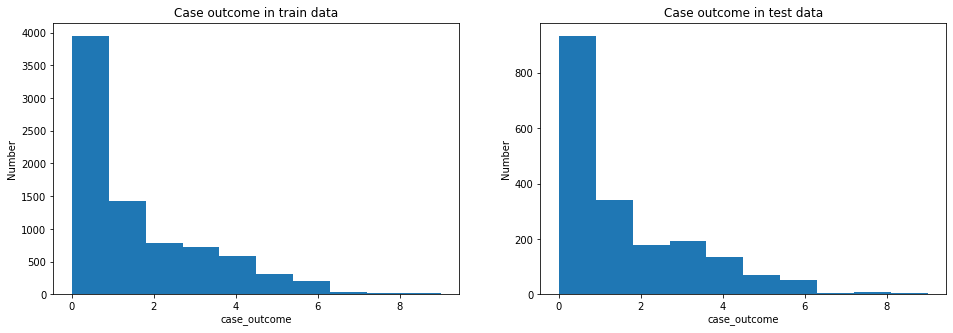

In [25]:
plt.figure(figsize = (16, 5))
plt.subplot(1, 2, 1)
plt.hist(train.select("label").rdd.flatMap(lambda x: x).collect())
plt.xlabel("case_outcome")
plt.ylabel("Number")
plt.title("Case outcome in train data")

plt.subplot(1, 2, 2)
plt.hist(test.select("label").rdd.flatMap(lambda x: x).collect())
plt.xlabel("case_outcome")
plt.ylabel("Number")
plt.title("Case outcome in test data")

plt.show()

## 4. Build and evaluate ML classification model

There are various classification algorithms. Here, only Decision Tree and Random Forest were tried and tested. Both expect name of label column and name of features column. Tree-based models tend to overfit data. For this reason, their learing capacity was restrained by regularizing tree depth up to 6 levels, and up to 10 estimators in the Random Forest. 

In [26]:
dt = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features', maxDepth = 6)
rf = RandomForestClassifier(labelCol = 'label', featuresCol = 'features', maxDepth = 6, numTrees = 10)

The function below helps to peform all modelling computations, including training, to predict labels on test data, and to evaluate model performance in terms of its accuracy, f1, weighted precision, and weighted recall.

In [27]:
def modelling(model, train, test):
  """
  Trains model, computes predictions on test data, and evaluates the model 
    performance in terms of its accuracy.
  Args: model: instantiated PySpark Machine Learning algorithm
        train: train data (spark preprocessed dataframe)
        test: test data (spark preprocessed dataframe)
  """
  model = model.fit(train)
  predictions = model.transform(test)
  predictions.show(5)
  evaluator_acc = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "accuracy")
  evaluator_f1 = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "f1")
  evaluator_wprec = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "weightedPrecision")
  evaluator_wrecall = MulticlassClassificationEvaluator(labelCol = "label", predictionCol = "prediction", metricName = "weightedRecall")
  accuracy = evaluator_acc.evaluate(predictions)
  f1 = evaluator_f1.evaluate(predictions)
  weighted_recall = evaluator_wrecall.evaluate(predictions)
  weighted_precision = evaluator_wprec.evaluate(predictions)

  print(f"Test Accuracy: {accuracy:.2f}")
  print(f"Test f1 score: {f1:.2f}")
  print(f"Test weighted recall: {weighted_recall:.2f}")
  print(f"Test weighted precision: {weighted_precision:.2f}")

Model performance is far from good both with Decision Tree and Random Forest. Their accuracy couldn't reach 50%, which means that half of the test samples were wrongly classified. High error rates (low values on all evaluation metrics), hence underfitting could be explained with noisy data, with building not so complex models (I introduced regularization to speed up training and to avoid overfitting), or with unsufficient training data. 

It should be said however, that a Kaggle user didn't reach much higher scores with `scikit-learn`'s Support Vector Classifier, Logistic Regression, Multinomial NaiveBayes, and Random Forest Classifier (referenced solution could be found [here](https://www.kaggle.com/code/sasakitetsuya/nlp-multi-categories-prediction-trial-2).)

In [28]:
modelling(dt, train, test)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(57144,[0,1,2,3,4...|[44.0,24.0,14.0,8...|[0.44,0.24,0.14,0...|       0.0|
|  0.0|(57144,[0,1,2,3,4...|[44.0,24.0,14.0,8...|[0.44,0.24,0.14,0...|       0.0|
|  0.0|(57144,[0,1,2,3,4...|[44.0,24.0,14.0,8...|[0.44,0.24,0.14,0...|       0.0|
|  0.0|(57144,[0,1,2,3,4...|[44.0,24.0,14.0,8...|[0.44,0.24,0.14,0...|       0.0|
|  0.0|(57144,[0,1,2,3,4...|[44.0,24.0,14.0,8...|[0.44,0.24,0.14,0...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows

Test Accuracy: 0.49
Test f1 score: 0.35
Test weighted recall: 0.49
Test weighted precision: 0.38


In [29]:
modelling(rf, train, test)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(57144,[0,1,2,3,4...|[4.22514466081003...|[0.42251446608100...|       0.0|
|  0.0|(57144,[0,1,2,3,4...|[4.22514466081003...|[0.42251446608100...|       0.0|
|  0.0|(57144,[0,1,2,3,4...|[4.22514466081003...|[0.42251446608100...|       0.0|
|  0.0|(57144,[0,1,2,3,4...|[6.39158162566000...|[0.63915816256600...|       0.0|
|  0.0|(57144,[0,1,2,3,4...|[6.39158162566000...|[0.63915816256600...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows

Test Accuracy: 0.49
Test f1 score: 0.32
Test weighted recall: 0.49
Test weighted precision: 0.24
